In [1]:
import torch
import requests
import kornia
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from transformers import AutoImageProcessor, AutoModel
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


url_image1 = "https://raw.githubusercontent.com/magicleap/SuperGluePretrainedNetwork/refs/heads/master/assets/phototourism_sample_images/united_states_capitol_98169888_3347710852.jpg"
image1 = Image.open(requests.get(url_image1, stream=True).raw)
url_image2 = "https://raw.githubusercontent.com/magicleap/SuperGluePretrainedNetwork/refs/heads/master/assets/phototourism_sample_images/united_states_capitol_26757027_6717084061.jpg"
image2 = Image.open(requests.get(url_image2, stream=True).raw)

images = [image1, image2]
print(images)

/home/mwuerstle@corp.exxcellent.de/miniconda3/envs/cv-project/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/mwuerstle@corp.exxcellent.de/miniconda3/envs/cv-project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1016x762 at 0x7DACC0649FD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1048x626 at 0x7DACC1921A90>]


In [2]:
image1 = Image.open('./result07.jpg')
image2 = Image.open('./result08.jpg')

images = [image1, image2]
print(images)

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7DACC084CA90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7DACC1907110>]


In [3]:
processor = AutoImageProcessor.from_pretrained("ETH-CVG/lightglue_superpoint")
model = AutoModel.from_pretrained("ETH-CVG/lightglue_superpoint")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
inputs = processor(images, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

image_sizes = [[(image.height, image.width) for image in images]]
outputs = processor.post_process_keypoint_matching(outputs, image_sizes, threshold=0.2)
for i, output in enumerate(outputs):
    print("For the image pair", i)
    for keypoint0, keypoint1, matching_score in zip(
            output["keypoints0"], output["keypoints1"], output["matching_scores"]
    ):
        print(
            f"Keypoint at coordinate {keypoint0.numpy()} in the first image matches with keypoint at coordinate {keypoint1.numpy()} in the second image with a score of {matching_score}."
        )


For the image pair 0
Keypoint at coordinate [108  29] in the first image matches with keypoint at coordinate [332  34] in the second image with a score of 0.3350704610347748.
Keypoint at coordinate [188  31] in the first image matches with keypoint at coordinate [411  32] in the second image with a score of 0.6253349184989929.
Keypoint at coordinate [252  32] in the first image matches with keypoint at coordinate [473  32] in the second image with a score of 0.35132530331611633.
Keypoint at coordinate [268  34] in the first image matches with keypoint at coordinate [492  32] in the second image with a score of 0.21186824142932892.
Keypoint at coordinate [276  34] in the first image matches with keypoint at coordinate [500  34] in the second image with a score of 0.5330343246459961.
Keypoint at coordinate [244  42] in the first image matches with keypoint at coordinate [467  44] in the second image with a score of 0.6974506378173828.
Keypoint at coordinate [614  48] in the first image m

/home/mwuerstle@corp.exxcellent.de/miniconda3/envs/cv-project/lib/python3.11/site-packages/transformers/models/lightglue/image_processing_lightglue.py:485: FutureWarning: `plot_keypoint_matching` is deprecated and will be removed in transformers v. Use `visualize_keypoint_matching` instead.
  warnings.warn(


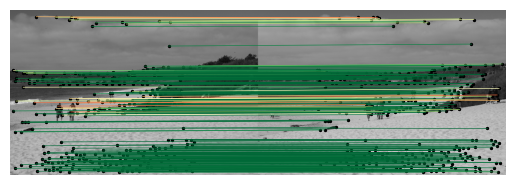

In [5]:
processor.plot_keypoint_matching(images, outputs)

In [6]:
import torch.nn.functional as F

def get_smooth_mask(mask, iterations=10):
    """ Smooths the edges of a binary mask using a simple box filter """
    for _ in range(iterations):
        mask = F.avg_pool2d(mask.unsqueeze(0), kernel_size=3, stride=1, padding=1).squeeze(0)
    return mask

In [7]:
def stitch_images(img0_pil, img1_pil, output):
    to_tensor = T.ToTensor()
    image0 = to_tensor(img0_pil)
    image1 = to_tensor(img1_pil)

    pts0 = output["keypoints0"].float()
    pts1 = output["keypoints1"].float()

    if pts0.shape[0] < 4:
        print("Insufficient matches for homography.")
        return None

    ransac = kornia.geometry.ransac.RANSAC(model_type='homography', inl_th=5.0, max_iter=1000)
    H, mask = ransac(pts1, pts0) 

    c, h0, w0 = image0.shape
    _, h1, w1 = image1.shape

    corners1 = torch.tensor([[0., 0.], [float(w1), 0.], [float(w1), float(h1)], [0., float(h1)]], device=device)
    corners1_homo = torch.cat([corners1, torch.ones((4, 1), device=device)], dim=1).T
    warped_homo = H @ corners1_homo
    warped_corners1 = (warped_homo[:2] / warped_homo[2]).T
    
    all_coords = torch.cat([warped_corners1, torch.tensor([[0., 0.], [float(w0), 0.], [float(w0), float(h0)], [0., float(h0)]], device=device)], dim=0)
    min_xy = all_coords.min(dim=0).values
    max_xy = all_coords.max(dim=0).values

    translation = torch.eye(3, device=image1.device)
    translation[0, 2] = -min_xy[0]
    translation[1, 2] = -min_xy[1]
    
    H_final = translation @ H
    out_size = (int(max_xy[1] - min_xy[1]), int(max_xy[0] - min_xy[0]))


    warped0 = kornia.geometry.transform.warp_perspective(
        image0.unsqueeze(0), translation.unsqueeze(0), dsize=out_size, padding_mode="zeros"
    ).squeeze(0)

    warped1 = kornia.geometry.transform.warp_perspective(
        image1.unsqueeze(0), H_final.unsqueeze(0), dsize=out_size, padding_mode="zeros"
    ).squeeze(0)


    # weight0 = get_feather_mask(warped0)
    # weight1 = get_feather_mask(warped1)

    mask0 = (warped0.abs().sum(dim=0, keepdim=True) > 1e-5).float()
    mask1 = (warped1.abs().sum(dim=0, keepdim=True) > 1e-5).float()
    
    stitched = (warped0 + warped1) / (mask0 + mask1 + 1e-8)    
    
    return stitched

/home/mwuerstle@corp.exxcellent.de/miniconda3/envs/cv-project/lib/python3.11/site-packages/kornia/geometry/homography.py:239: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1736083029558/work/aten/src/ATen/native/Cross.cpp:62.)
  torch.cross(src_perm[..., 1:2, :], src_perm[..., 2:3, :]) @ src_perm[..., 0:1, :].permute(0, 1, 3, 2)


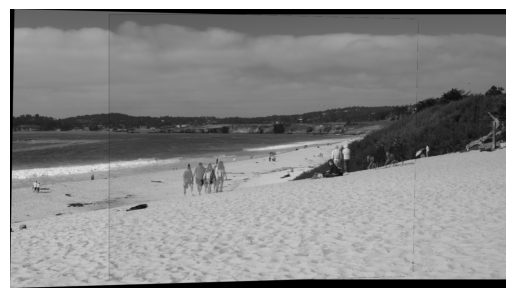

In [8]:
for i, output in enumerate(outputs):
    # Ensure images are float tensors [3, H, W] normalized to [0, 1]
    img_ref = images[0] 
    img_move = images[1]
    
    result = stitch_images(img_ref, img_move, output)
    
    if result is not None:
        plt.imshow(result.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.show()

In [9]:
image1 = Image.open('./DSC03002.JPG')
image2 = Image.open('./DSC03003.JPG')
image3 = Image.open('./DSC03004.JPG')
image4 = Image.open('./DSC03005.JPG')
image5 = Image.open('./DSC03006.JPG')

image_list = [image1, image2, image3, image4, image5]

In [10]:
def feature_detection_mapping(images):
    inputs = processor(images, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    image_sizes = [[(image.height, image.width) for image in images]]
    outputs = processor.post_process_keypoint_matching(outputs, image_sizes, threshold=0.2)
    return outputs


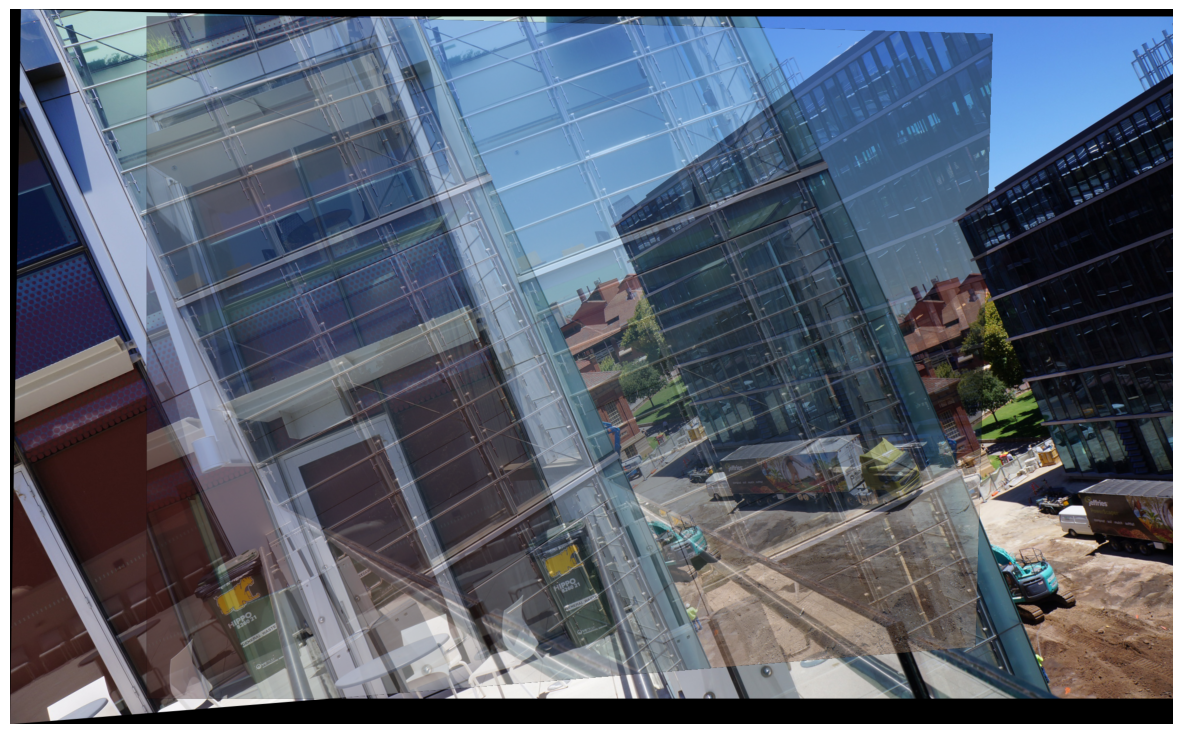

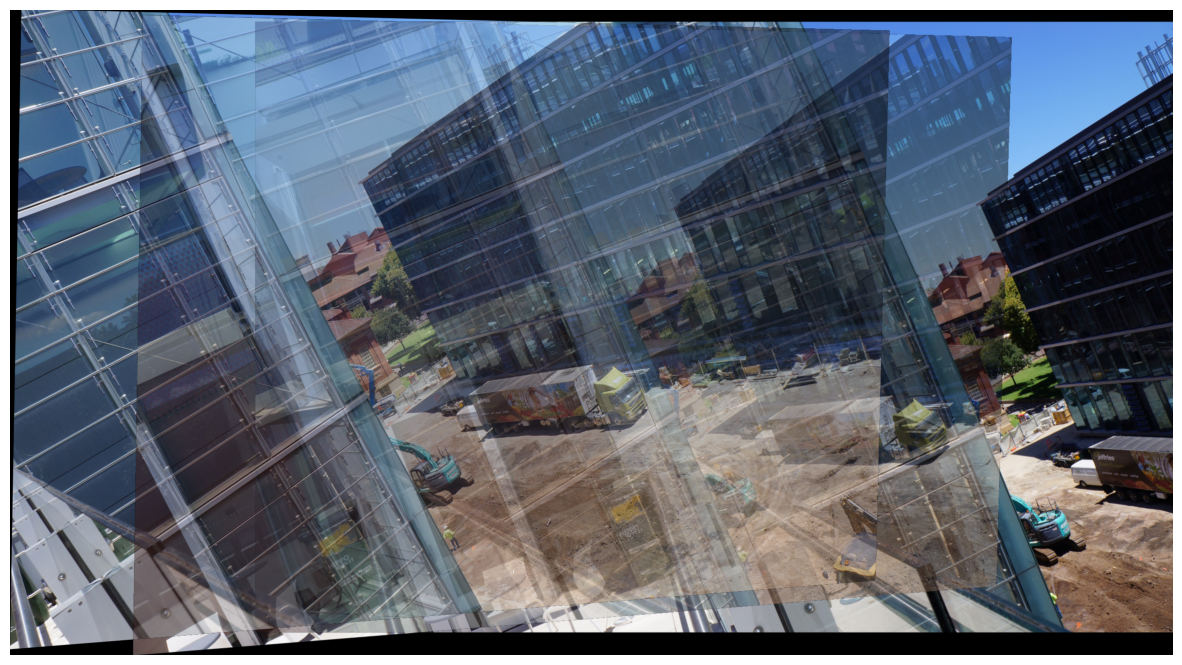

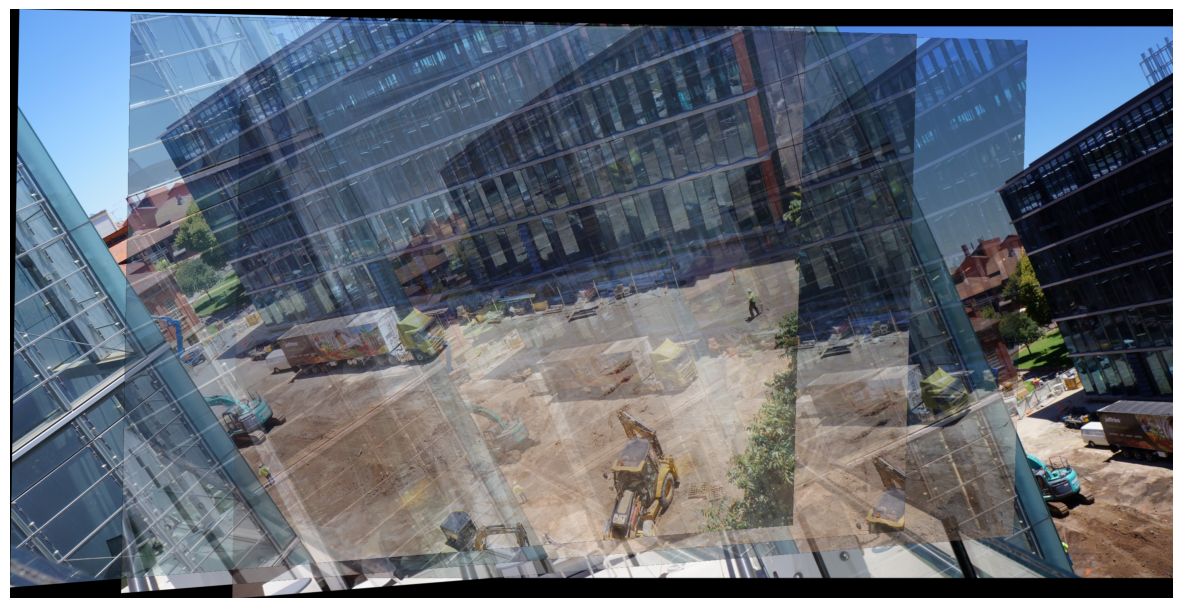

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..735.96545].


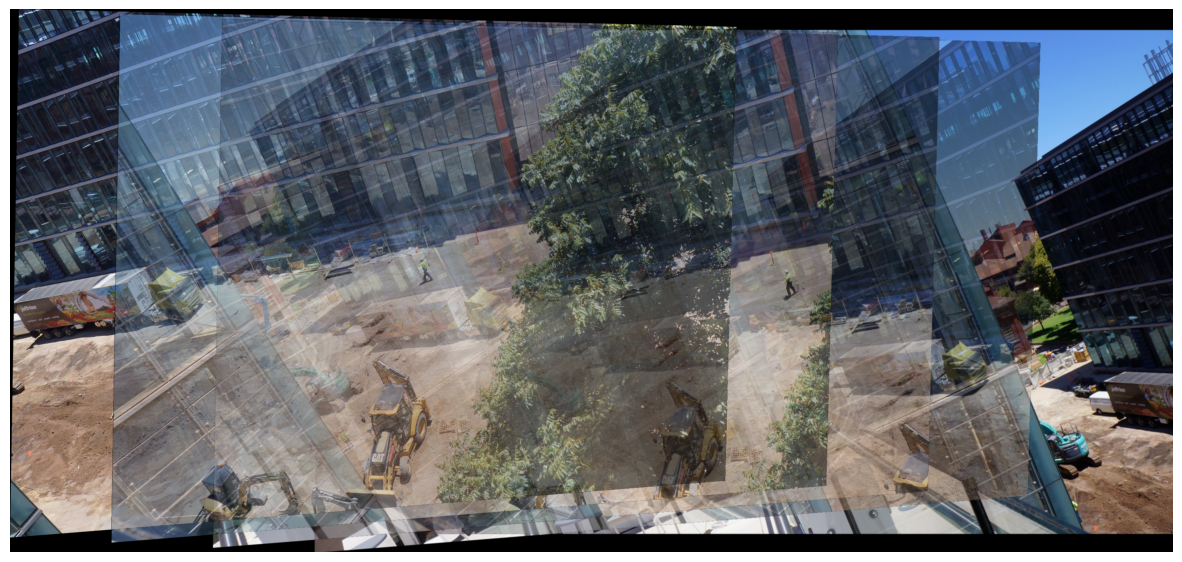

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..735.96545].


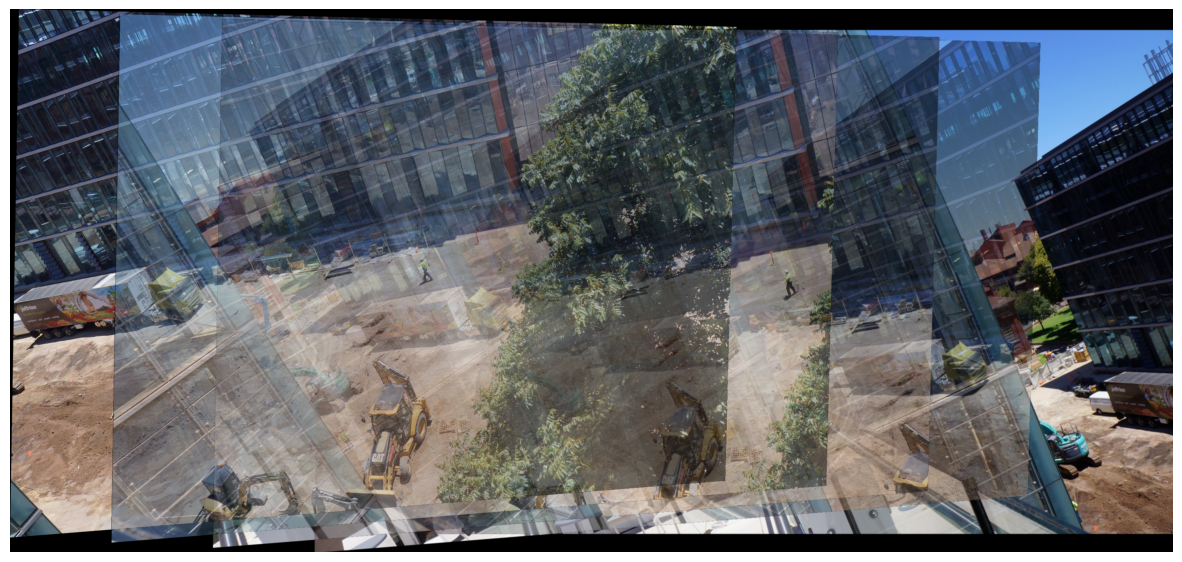

In [11]:
to_pil = T.ToPILImage()
images = [image_list[0], image_list[1]]
for image in image_list[1:]:
    images[1] = image
    output = feature_detection_mapping(images)

    for i, output in enumerate(outputs):
        img_a = images[0] 
        img_b = images[1]
        final = stitch_images(img_a, img_b, output)
        plt.figure(figsize=(15, 10))
        plt.imshow(final.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.show()
        images[0] = to_pil(final)

        
if final is not None:
    # Convert back to numpy for visualization
    plt.figure(figsize=(15, 10))
    plt.imshow(final.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()